In [1]:
import numpy as np
import pandas as pd 
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import warnings; warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv("train_8wry4cB.csv")
train.shape

(10500, 5)

## EDA 

In [3]:
#Function to manipulate timestamp column
def time_to_minutes(time_str): 
    '''function to convert time to min'''
    try: 
        t = time_str.split("days")[1].strip()
        hours, minutes, seconds = t.split(':')  
    except ValueError:  
        return -1  
    return int(hours)*60 + int(minutes) + int(seconds)/60.0  

#make a poduct list in a separate column
def split_category(s):
    '''Separate category from productlist'''
    s1 = s.split(";")
    c = []
    for i in s1:
        p = i.split("/")[0]
        if p not in c:
            c.append(p)
        else:
            pass
    return c  

#make a poduct list in a separate column
def split_product(s):
    '''Separate product from the productlist'''
    s1 = s.split(";")
    p = [i.split("/")[-2] for i in s1]
    return p 

def split_sub_category(s):
    '''Separate category from productlist'''
    s1 = s.split(";")
    c = []
    for i in s1:
        p = i.split("/")[1]
        if p not in c:
            c.append(p)
        else:
            pass
    return c  

def split_sub_sub(s):
    '''Separate category from productlist'''
    s1 = s.split(";")
    c = []
    for i in s1:
        p = i.split("/")[2]
        if p not in c:
            c.append(p)
        else:
            pass
    return c 

In [4]:
#Feature engineering from time stamp 
import datetime
from datetime import timedelta
train["startTime"] = pd.to_datetime(train["startTime"], format= '%d/%m/%y %H:%M')
train["endTime"] = pd.to_datetime(train["endTime"], format = '%d/%m/%y %H:%M')
train["sessionTime"] = pd.DataFrame(train["endTime"] - train["startTime"])
train["Weekday"] = train["startTime"].apply(lambda x: x.weekday())
train['Hour'] = train["startTime"].dt.hour
train["sessionTime"] = train["sessionTime"].apply(lambda x: str(x))
train["Total_time"] = train["sessionTime"].apply(lambda x: time_to_minutes(x))
train["Number_Of_Products"] = train["ProductList"].apply(lambda x: len(x.split(";")))

In [5]:
train["Number_Of_Products"].describe()

count    10500.000000
mean         2.214381
std          2.311911
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         36.000000
Name: Number_Of_Products, dtype: float64

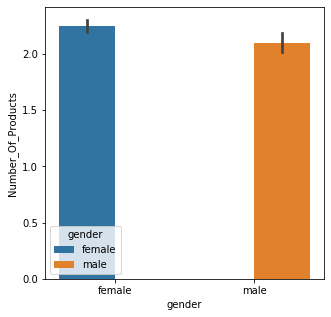

In [6]:
#find who bought most of the products/who shopped the most male or female
plt.figure(figsize=(5,5))
sns.barplot("gender","Number_Of_Products", data = train, hue = "gender")

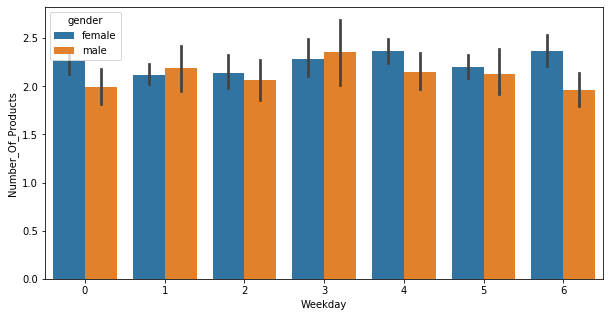

In [7]:
# who shopped most in any weekday
plt.figure(figsize = (10, 5))
sns.barplot("Weekday", "Number_Of_Products", data = train, hue = "gender")

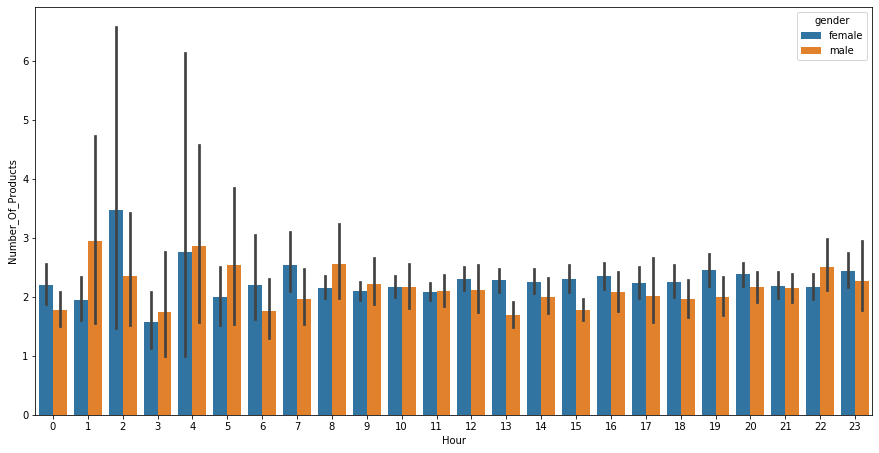

In [8]:
#who shopped mostly in any hour of the day
plt.figure(figsize = (15, 7.5))
sns.barplot("Hour", "Number_Of_Products", data = train, hue = "gender")

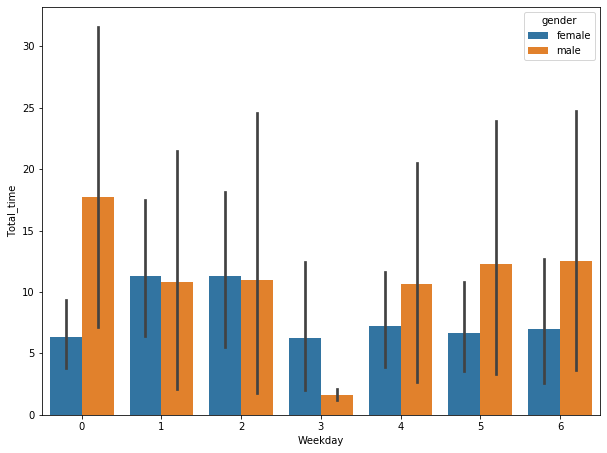

In [9]:
#Who spent most of the time in product viewing in a weekday
plt.figure(figsize = (10, 7.5))
sns.barplot("Weekday", "Total_time", data = train, hue = "gender")

-- Error bars are high in this lets verify if any out liers are there by box plot

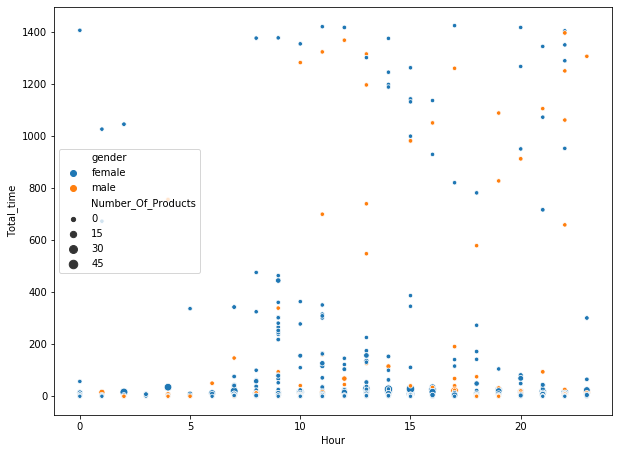

In [43]:
plt.figure(figsize = (10, 7.5))
sns.scatterplot("Hour", "Total_time", data=train, hue = "gender", 
                size = "Number_Of_Products", alpha= 1)
plt.xlabel('Hour')
plt.ylabel('Total_time')
plt.show()

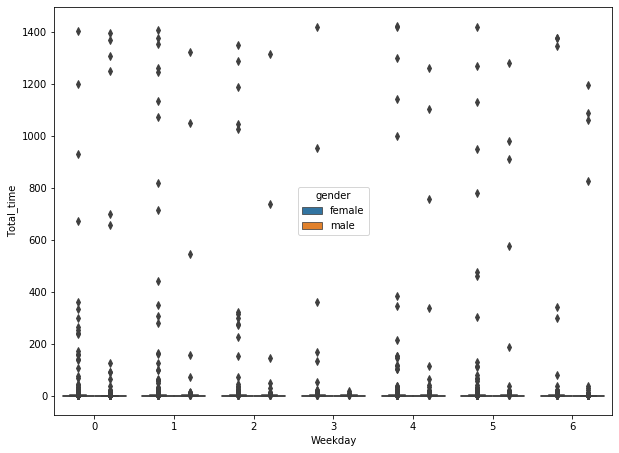

In [10]:
plt.figure(figsize = (10, 7.5))
sns.boxplot("Weekday", "Total_time", data = train, hue = "gender")

## Detecting outliers

> There is a huge difference between Q3(75%) and Max 
We can detect outliers in the data using <b> anamoly detection algorithms <b>
    
    .Simple Statistical Methods
    
    .Machine Learning-Based Approach

 <b>Statistical method to detect anamoly or outliers in the data <b>

In [94]:
train.groupby("gender")["Total_time"].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,8192.0,7.910034,78.253796,0.0,0.0,0.0,2.0,1425.0
male,2308.0,12.032929,104.140400,0.0,0.0,0.0,2.0,1397.0


/Users/srinivasaluri/anaconda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


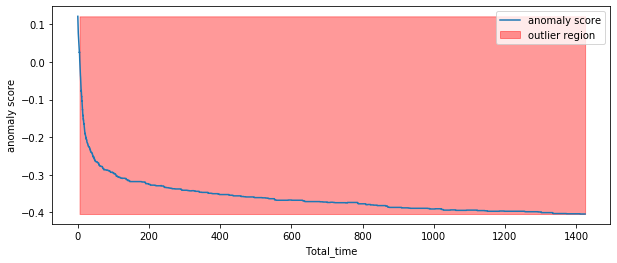

In [12]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(train["Total_time"].values.reshape(-1, 1))
xx = np.linspace(train["Total_time"].min(), train["Total_time"].max(), len(train)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)  
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label="anomaly score")
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label= "outlier region")
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel("Total_time") 
plt.show()

In [45]:
# Above 0 and 1 min are determined as outliers which is a length of 200 rows.
# Lets see how many number of products they have bought at the time.


12.0      36
11.0      33
13.0      24
14.0      21
15.0      15
          ..
579.0      1
1089.0     1
1290.0     1
44.0       1
1143.0     1
Name: Total_time, Length: 155, dtype: int64

## Feature engineering 
1) Total number of produts per session id

2) Hour of purchase

3) Total session time per user

4) At what day of week purchases are made


In [95]:
#Feature engineering for products
prod = train["ProductList"].apply(lambda x: split_product(x))
cat = train["ProductList"].apply(lambda x: split_category(x))
sub_cat = train["ProductList"].apply(lambda x: split_sub_category(x))
sub_sub = train["ProductList"].apply(lambda x: split_sub_sub(x))

In [96]:
#Get dummies for Products
prod_dummy = pd.get_dummies(prod.apply(pd.Series).stack()).sum(level=0)
cat_dummy = pd.get_dummies(cat.apply(pd.Series).stack()).sum(level=0)
sub_dummy = pd.get_dummies(sub_cat.apply(pd.Series).stack()).sum(level=0)
sub_sub_dummy = pd.get_dummies(sub_sub.apply(pd.Series).stack()).sum(level=0)

In [98]:
print(prod_dummy.shape, cat_dummy.shape, sub_dummy.shape, sub_sub_dummy.shape)

(10500, 16503) (10500, 11) (10500, 85) (10500, 360)


In [99]:
train2 = pd.concat([train, cat_dummy], axis = 1)

In [100]:
train2.shape

(10500, 21)

In [101]:
train2 = train2.drop(["session_id", "startTime", "endTime", 
                      "ProductList", "sessionTime"], axis = 1)
train2["gender"].replace(["male", "female"], [1,0], inplace = True)
train2[1:5]

,gender,Weekday,Hour,Total_time,Number_Of_Products,A00001,A00002,A00003,A00004,A00005,A00006,A00007,A00008,A00009,A00010,A00011
1,1,1,14,6.0,7,1,0,0,0,0,0,0,0,0,0,0
2,0,0,15,0.0,1,0,1,0,0,0,0,0,0,0,0,0
3,0,6,2,3.0,3,0,1,0,0,0,0,0,0,0,0,0
4,1,2,16,2.0,2,1,0,0,0,0,0,0,0,0,0,0


In [102]:
train2.shape

(10500, 16)

## Base model Logistic regression by giving class weights
- there is sample imbalance

In [103]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.metrics import confusion_matrix

In [104]:
X = train2[train2["Total_time"] < 30].drop("gender", axis = 1)
y = train2[train2["Total_time"] < 30].gender

In [105]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25,
                                                    random_state =10)

print(X_train.shape, X_val.shape)

(7759, 15) (2587, 15)


In [106]:
y_train.value_counts()

0    6042
1    1717
Name: gender, dtype: int64

In [107]:
logit = LogisticRegression(C = 1.0, class_weight={1:3, 0:1}, solver= "lbfgs")
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_val_scale = scale.fit_transform(X_val)
logit.fit(X_train_scale,y_train)
print(logit.score(X_train_scale, y_train)) 

0.8624822786441552


In [108]:
preds = logit.predict(X_val_scale)
prob = logit.predict_proba(X_val_scale)
print(accuracy_score(y_val, preds),
      precision_score(y_val, preds),
      recall_score(y_val, preds),
      f1_score(y_val, preds),
     roc_auc_score(y_val, preds))

0.8759180517974487 0.7341513292433538 0.6527272727272727 0.6910490856592878 0.7944539652787076


In [109]:
#CONFUSION MATRIX clearly indicates effect of sample imbalence 
confusion_matrix(y_val, preds)

array([[1907,  130],
       [ 191,  359]])

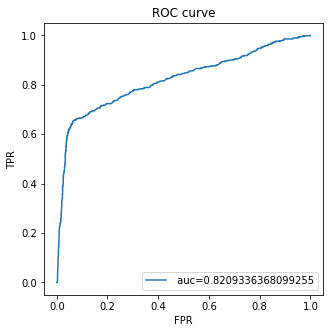

In [110]:
prob = logit.predict_proba(X_val_scale)[:,1]
plt.figure(figsize = (5, 5))
fpr_logit, tpr_logit, thresholds = roc_curve(y_val,prob)
auc_val = np.trapz(tpr_logit,fpr_logit)
plt.plot(fpr_logit,tpr_logit,label=" auc="+str(auc_val))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show() 

-- Logistic could not give better f1 score, recall_score and roc_auc_score

## Using SMOTE for oversampling

In [147]:
#Using SMOTE for oversampling
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=10).fit_sample(X_train,y_train)
print(y_train.value_counts(), np.bincount(y_smoted))

0    6042
1    1717
Name: gender, dtype: int64 [6042 6042]


In [150]:
logit = LogisticRegression(C = 1.0, solver= "lbfgs")
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_smoted)
X_val_scale = scale.fit_transform(X_val)
logit.fit(X_train_scale,y_smoted)
print(logit.score(X_train_scale, y_smoted)) 

0.781777557100298


In [151]:
preds = logit.predict(X_val_scale)
prob = logit.predict_proba(X_val_scale)
print(accuracy_score(y_val, preds),
      precision_score(y_val, preds),
      recall_score(y_val, preds),
      f1_score(y_val, preds),
     roc_auc_score(y_val, preds))

0.8678005411673754 0.6992337164750958 0.6636363636363637 0.6809701492537313 0.7932811175079216


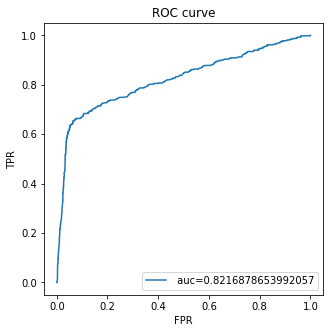

In [143]:
prob = logit.predict_proba(X_val_scale)[:,1]
plt.figure(figsize = (5, 5))
fpr_logit, tpr_logit, thresholds = roc_curve(y_val,prob)
auc_val = np.trapz(tpr_logit,fpr_logit)
plt.plot(fpr_logit,tpr_logit,label=" auc="+str(auc_val))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show() 

In [144]:
#CONFUSION MATRIX clearly indicates effect of sample imbalence 
confusion_matrix(y_val, preds)

array([[1880,  157],
       [ 185,  365]])

## XGBoost

In [115]:
#Grid search to find best parameters for XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
model = XGBClassifier()
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.819310 using {'scale_pos_weight': 1}


In [116]:
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.819310 (0.020251) with: {'scale_pos_weight': 1}
0.818468 (0.018699) with: {'scale_pos_weight': 10}
0.817422 (0.017621) with: {'scale_pos_weight': 25}
0.817326 (0.019377) with: {'scale_pos_weight': 50}
0.816285 (0.020677) with: {'scale_pos_weight': 75}
0.816213 (0.019929) with: {'scale_pos_weight': 99}
0.816403 (0.019695) with: {'scale_pos_weight': 100}
0.815094 (0.019805) with: {'scale_pos_weight': 1000}


In [117]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=6, max_features='sqrt', min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,scoring = 'roc_auc',
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [146]:
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
preds = xgb.predict(X_val)
prob = xgb.predict_proba(X_val)
print(accuracy_score(y_val, preds),
      precision_score(y_val, preds),
      recall_score(y_val, preds),
      f1_score(y_val, preds),
     roc_auc_score(y_val, preds))

0.8820724320144349
0.8763045999226904 0.7649769585253456 0.6036363636363636 0.6747967479674798 0.7767813629669299


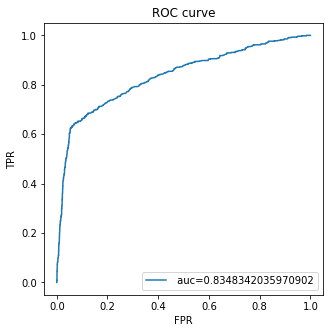

In [120]:
prob = xgb.predict_proba(X_val)[:,1]
plt.figure(figsize = (5, 5))
fpr_logit, tpr_logit, thresholds = roc_curve(y_val,prob)
auc_val = np.trapz(tpr_logit,fpr_logit)
plt.plot(fpr_logit,tpr_logit,label=" auc="+str(auc_val))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show() 

LogisticRegression Model best F1 score 0.356 at prob decision threshold >= 0.431


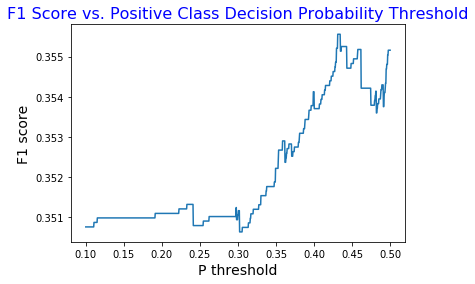

In [121]:
#dummy threshold
thresh_ps = np.linspace(.10,.50,1000)
#predicting probabilities
prob = logit.predict_proba(X_val)[:, 1]
f1_scores = []
for p in thresh_ps:
    prob_labels = prob >= p
    f1_scores.append(f1_score(y_val, prob_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold', fontsize = 16, color = 'blue')
plt.xlabel('P threshold', fontsize = 14)
plt.ylabel('F1 score', fontsize = 14)

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('LogisticRegression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [122]:
#CONFUSION MATRIX clearly indicates effect of sample imbalence 
confusion_matrix(y_val, preds)

array([[1935,  102],
       [ 218,  332]])

## Predict on test

In [123]:
## predict on test set
test = pd.read_csv("test_Yix80N0.csv")
test.shape

(4500, 4)

In [124]:
test[1:10]

,session_id,startTime,endTime,ProductList
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00...
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/
5,u11327,27/11/14 8:41,27/11/14 8:47,A00001/B00009/C00028/D13690/;A00001/B00009/C00...
6,u12768,26/11/14 21:23,26/11/14 21:24,A00001/B00031/C00044/D13454/
7,u17011,25/11/14 20:02,25/11/14 20:03,A00001/B00009/C00028/D11956/
8,u13527,20/12/14 16:26,20/12/14 16:26,A00002/B00003/C00005/D26497/
9,u24492,18/12/14 13:15,18/12/14 13:19,A00001/B00001/C00019/D04978/;A00001/B00001/C00...


In [129]:
test["startTime"] = pd.to_datetime(test["startTime"], format= '%d/%m/%y %H:%M')
test["endTime"] = pd.to_datetime(test["endTime"], format = '%d/%m/%y %H:%M')
test["sessionTime"] = pd.DataFrame(test["endTime"] - test["startTime"])
test["Weekday"] = test["startTime"].apply(lambda x: x.weekday())
test['Hour'] = train["startTime"].dt.hour
test["sessionTime"] = test["sessionTime"].apply(lambda x: str(x))
test["Total_time"] = test["sessionTime"].apply(lambda x: time_to_minutes(x))
test["Number_Of_Products"] = test["ProductList"].apply(lambda x: len(x.split(";")))

In [130]:
prod = test["ProductList"].apply(lambda x: split_product(x))
cat = test["ProductList"].apply(lambda x: split_category(x))
sub_cat = test["ProductList"].apply(lambda x: split_sub_category(x))
sub_sub = test["ProductList"].apply(lambda x: split_sub_sub(x)) 

In [131]:
#Get dummies
prod_dummy = pd.get_dummies(prod.apply(pd.Series).stack()).sum(level=0)
cat_dummy = pd.get_dummies(cat.apply(pd.Series).stack()).sum(level=0)
sub_dummy = pd.get_dummies(sub_cat.apply(pd.Series).stack()).sum(level=0)
sub_sub_dummy = pd.get_dummies(sub_sub.apply(pd.Series).stack()).sum(level=0)

In [132]:
test2 = pd.concat([test, cat_dummy], axis = 1)

In [133]:
test2 = test2.drop(["session_id", "startTime", "endTime", 
                      "ProductList", "sessionTime"], axis = 1)

In [134]:
test2.shape

(4500, 15)

In [138]:
preds = xgb.predict(test2)[]

array([0, 0, 0, ..., 0, 1, 0])

In [139]:
pd.DataFrame(zip(test["session_id"], preds), columns= ["session_id", "gender_pred"])

,session_id,gender_pred
0,u12112,0
1,u19725,1
2,u11795,0
3,u22639,0
4,u18034,0
5,u11327,0
6,u12768,0
7,u17011,0
8,u13527,0
9,u24492,0
